In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score # AUC score
from sklearn.metrics import average_precision_score # AUPR score
from sklearn.metrics import precision_recall_fscore_support # precision, recall
from imblearn.metrics import sensitivity_specificity_support # sensitivity, specificity
from sklearn.metrics import roc_curve # to draw auc curve
from sklearn.metrics import precision_recall_curve # to draw aupr curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 2017.4.19.
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/1_feature_based-Systematic/2_PREDICT_dataset/2_TN_local/2_normalize_indep_check/"
#df = pd.read_table(path + "6_tn_local_norm_descriptor.tsv")
# 2017.4.20. P:TN = 1: 15
#df = pd.read_table(path + "6_4_1_tn_local_norm_1_15_descriptor.tsv")
# 2017.4.20. P:TN = 1: 20
#df = pd.read_table(path + "6_4_2_tn_local_norm_1_20_descriptor.tsv")
# 2017.4.20. P:TN = 1: 30
#df = pd.read_table(path + "6_4_3_tn_local_norm_1_30_descriptor.tsv")
#2017.4.24. P:TN = 1:1
df = pd.read_table(path + "6_4_4_tn_local_norm_1_1_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [3]:
# 2017.4.19.independent dataset
path = "/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/1_feature_based-Systematic/2_PREDICT_dataset/"
indep = pd.read_table(path + "2_2_indep_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [4]:
# undersampler
rus = RandomUnderSampler()
oss = OneSidedSelection()
nm = NearMiss()

In [5]:
def Random_Forest_K_fold_graph(X, y, k, user_estimator):
    
    skf = StratifiedKFold(n_splits=k, shuffle=True) # n_splits = k (k fold라서.), pos:neg의 비율을 고려해서 k 개의 subgroup으로 나누어줌.
    folds_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    for training_index, validation_index in skf.split(X, y):
        x_training_set = X[training_index]
        y_training_set = y[training_index]
        x_validation_set = X[validation_index]
        y_validation_set = y[validation_index]
        
        classifier = RandomForestClassifier(n_estimators=user_estimator, n_jobs=-1, class_weight='balanced') #n_jobs=-1 이면 모든 node 쓰는것, 신경쓰이면 30개 정도.
        classifier.fit(x_training_set, y_training_set)
        
        y_predicted_proba = classifier.predict_proba(x_validation_set) # [0에 대한 확률, 1에 대한 확률], shpae = [n_samples, n_class]
        y_predicted_label = classifier.predict(x_validation_set) # 예측된 label을 보여줌, shpae = [n_samples]
        
        # Accuracy 
        current_acc = classifier.score(x_validation_set, y_validation_set)
        folds_results['acc'].append(current_acc)

        # AUC
        current_auc = roc_auc_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['auc'].append(current_auc)
        
        # Sensitivity, Specificity
        sn, sp, support = sensitivity_specificity_support(y_validation_set, y_predicted_label)
        folds_results['sn'].append(sn)
        folds_results['sp'].append(sp)
        
        # AUPR
        current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:,1])
        folds_results['aupr'].append(current_aupr)
        
        # Precision, Recall
        precision, recall, _, _ =  precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        folds_results['precision'].append(precision)
        folds_results['recall'].append(recall)
        
        # Confusion Matrix
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        folds_results['confusion_matrix'].append(current_confusion_matrix)
        
        #draw graph
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1)
        draw_results['fpr'].append(fpr)
        draw_results['tpr'].append(tpr)
        
        precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1])
        draw_results['precision_vec'].append(precision_vec)
        draw_results['recall_vec'].append(recall_vec)
        
    return folds_results, draw_results

In [6]:
def draw_plot(draw_results, final_result, user_c):
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna']
    lw = 1
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    print "{}------------------------------------".format(user_c)
    for i in draw_results:
        for fpr, tpr in zip(i['fpr'], i['tpr']):
            ax1.plot(fpr, tpr, lw=lw)
        for recall_vec, precision_vec in zip(i['recall_vec'], i['precision_vec']):
            ax2.plot(recall_vec, precision_vec, lw=lw)
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_color_cycle(colors)
    ax1.set_title('C={0}, Average AUC={1:0.2f}'.format(user_c, final_result['auc']))
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_color_cycle(colors)
    ax2.set_title('C={0}, Average AUPR={1:0.2f}'.format(user_c, final_result['aupr']))
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    plt.tight_layout()
    plt.show()

In [7]:
def average_result(folds_results):
    avg_result = dict()
    avg_result['avg_acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
    avg_result['avg_auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
    avg_result['avg_aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
    avg_result['avg_sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
    avg_result['avg_sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
    avg_result['avg_precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
    avg_result['avg_recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
    avg_result['sum_confusion_matrix'] = sum(folds_results['confusion_matrix'])
    
    return avg_result

In [8]:
def independent_results(param_result):
    indep_results = {'indep_acc':[], 'indep_auc':[], 'indep_aupr':[], 'indep_confusion_matrix':[],
                     'indep_sn':[], 'indep_sp':[], 'indep_precision':[], 'indep_recall':[]}
    for fold in param_result:
        indep_results['indep_acc'].append(fold['avg_acc'])
        indep_results['indep_auc'].append(fold['avg_auc'])
        indep_results['indep_aupr'].append(fold['avg_aupr'])
        indep_results['indep_sn'].append(fold['avg_sn'])
        indep_results['indep_sp'].append(fold['avg_sp'])
        indep_results['indep_precision'].append(fold['avg_precision'])
        indep_results['indep_recall'].append(fold['avg_recall'])
        indep_results['indep_confusion_matrix'].append(fold['sum_confusion_matrix'])
    return indep_results

In [9]:
def final_results (indep_results):
    results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[],
               'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    results['acc'] = sum(indep_results['indep_acc']) / len(indep_results['indep_acc'])
    results['auc'] = sum(indep_results['indep_auc']) / len(indep_results['indep_auc'])
    results['aupr'] = sum(indep_results['indep_aupr']) / len(indep_results['indep_aupr'])
    results['sn'] = sum(indep_results['indep_sn']) / len(indep_results['indep_sn'])
    results['sp'] = sum(indep_results['indep_sp']) / len(indep_results['indep_sp'])
    results['precision'] = sum(indep_results['indep_precision']) / len(indep_results['indep_precision'])
    results['recall'] = sum(indep_results['indep_recall']) / len(indep_results['indep_recall'])
    results['confusion_matrix'] = sum(indep_results['indep_confusion_matrix'])
    return results

In [10]:
def write_output(fd, write_results, user_c):
    fd.write("N={}-------------------------------------------------\r\n".format(user_c))
    fd.write("Accuracy avg : {}\r\n".format(write_results['acc']))
    fd.write("AUC avg : {}\r\n".format(write_results['auc']))
    fd.write("  Sensitivity avg : {}\r\n".format(write_results['sn']))
    fd.write("  Specificity avg : {}\r\n".format(write_results['sp']))
    fd.write("AUPR avg : {}\r\n".format(write_results['aupr']))
    fd.write("  Precision avg : {}\r\n".format(write_results['precision']))
    fd.write("  Recall avg : {}\r\n".format(write_results['recall']))
    fd.write("confusion amtrix : {}\r\n".format(write_results['confusion_matrix']))

2017-04-24 10:16:14
120------------------------------------


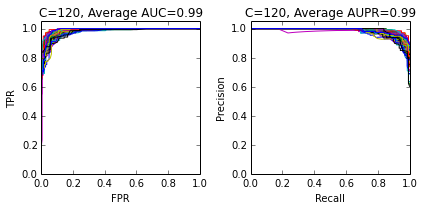

300------------------------------------


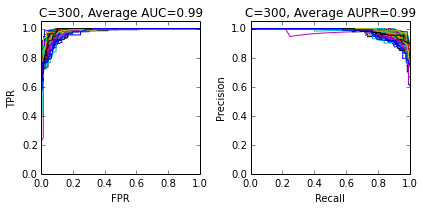

500------------------------------------


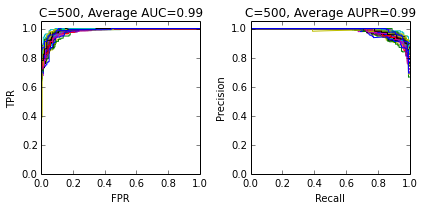

800------------------------------------


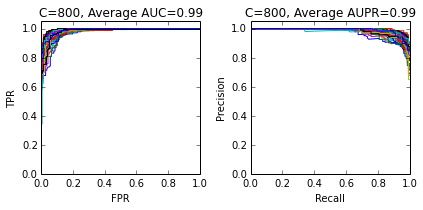

1200------------------------------------


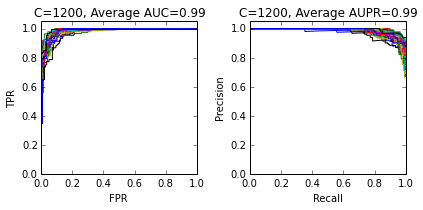

2017-04-24 10:30:25
120------------------------------------


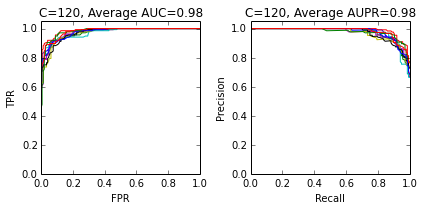

300------------------------------------


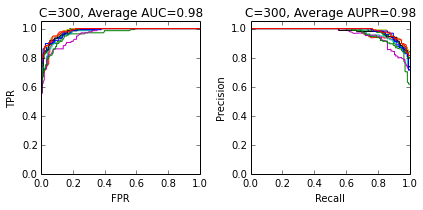

500------------------------------------


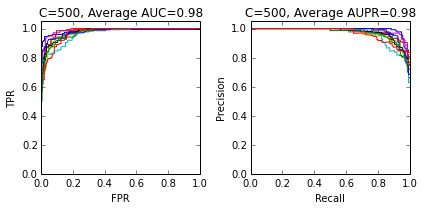

800------------------------------------


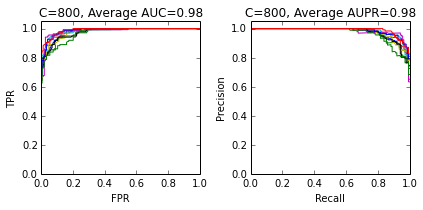

1200------------------------------------


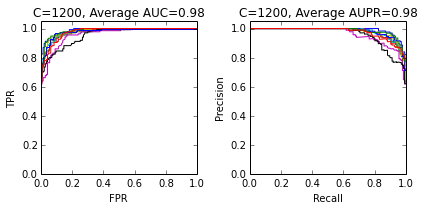

2017-04-24 10:33:22


In [209]:
# RandomForest_K_fold_grpah + 파일 입출력
# PREDICT TN local norm(P:TN = 1:1), undersampling(1:1) , 2017.4.24.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_RF_tn_local_norm_training(1_1)_10-fold.txt", 'w') as fd :
    fd.write("<10 times independent test : undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 5 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    fd.write("<no independent test -> no undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 1 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        #x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-04-24 13:18:43
120------------------------------------


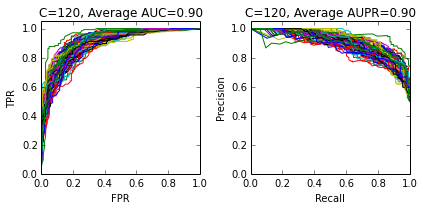

300------------------------------------


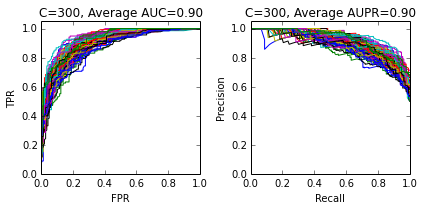

500------------------------------------


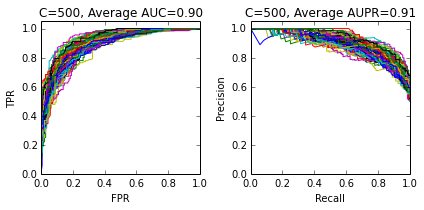

800------------------------------------


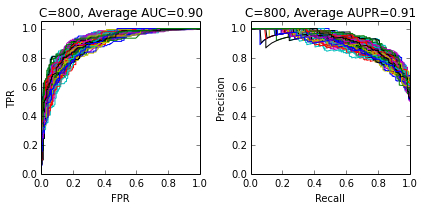

1200------------------------------------


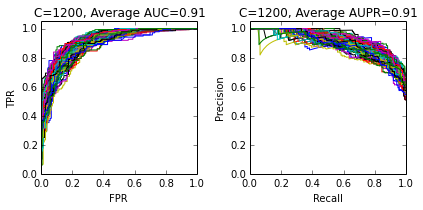

2017-04-24 13:47:05
120------------------------------------


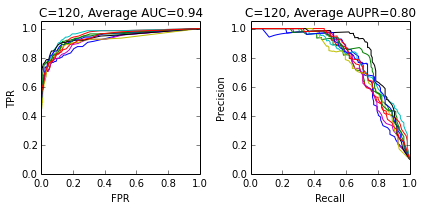

300------------------------------------


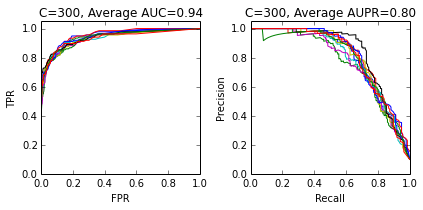

500------------------------------------


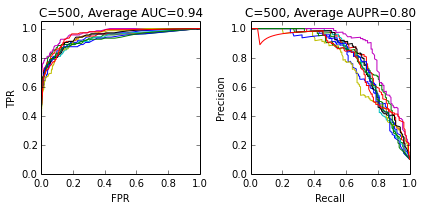

800------------------------------------


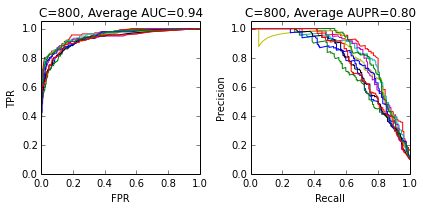

1200------------------------------------


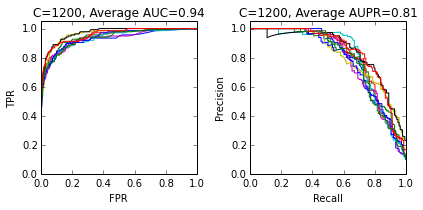

2017-04-24 13:59:36


In [211]:
# RandomForest_K_fold_grpah + 파일 입출력
# PREDICT TN local norm, undersampling , 2017.4.19.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_RF_tn_local_norm_training_10-fold.txt", 'w') as fd :
    fd.write("<10 times independent test : undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 10 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    fd.write("<no independent test -> no undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 1 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        #x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [11]:
def Random_Forest_independent_graph(X, y, indep_X, indep_y, user_estimator):

    folds_results = dict()
    draw_results = {'fpr':[], 'tpr':[], 'precision_vec':[], 'recall_vec':[]}
    fp_results = dict()
    
    classifier = RandomForestClassifier(n_estimators=user_estimator, n_jobs=-1, class_weight='balanced')
    classifier.fit(X, y)
    indep_y_predicted_proba = classifier.predict_proba(indep_X)
    indep_y_predicted_label = classifier.predict(indep_X)
    fp_results['predicted_proba'] = indep_y_predicted_proba
    fp_results['Predicted_label'] = indep_y_predicted_label
    fp_results['y_true'] = indep_y

    # Accuracy
    indep_acc = classifier.score(indep_X, indep_y)
    folds_results['acc']=indep_acc
    
    # AUC
    indep_auc = roc_auc_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['auc']=indep_auc
    
    # Sensitivity, Specificity
    indep_sn, indep_sp, support = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    folds_results['sn']=indep_sn
    folds_results['sp']=indep_sp
    
    # AUPR
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:,1])
    folds_results['aupr']=indep_aupr
    
    # Precision, Recall
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    folds_results['precision']=indep_precision
    folds_results['recall']=indep_recall
    
    # Confusion Matirx
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    folds_results['confusion_matrix']=indep_confusion_matirx
    
    # draw graph
    indep_fpr, indep_tpr, thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label=1)
    draw_results['fpr'].append(indep_fpr)
    draw_results['tpr'].append(indep_tpr)
        
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    draw_results['precision_vec'].append(indep_precision_vec)
    draw_results['recall_vec'].append(indep_recall_vec)

    return folds_results, draw_results, fp_results

In [12]:
def seperate_results(indep_results):
    temp_results = {'acc':[], 'auc':[], 'aupr':[], 'confusion_matrix':[], 'sn':[], 'sp':[], 'precision':[], 'recall':[]}
    for i in range(independent_count):
        temp_results['acc'].append(indep_results[i]['acc'])
        temp_results['auc'].append(indep_results[i]['auc'])
        temp_results['aupr'].append(indep_results[i]['aupr'])
        temp_results['confusion_matrix'].append(indep_results[i]['confusion_matrix'])
        temp_results['sn'].append(indep_results[i]['sn'])
        temp_results['sp'].append(indep_results[i]['sp'])
        temp_results['precision'].append(indep_results[i]['precision'])
        temp_results['recall'].append(indep_results[i]['recall'])
    return temp_results
def average_result(folds_results):
    avg_result = dict()
    avg_result['acc'] = sum(folds_results['acc']) / len(folds_results['acc'])
    avg_result['auc'] = sum(folds_results['auc']) / len(folds_results['auc'])
    avg_result['aupr'] = sum(folds_results['aupr']) / len(folds_results['aupr'])
    avg_result['sn'] = sum(folds_results['sn']) / len(folds_results['sn'])
    avg_result['sp'] = sum(folds_results['sp']) / len(folds_results['sp'])
    avg_result['precision'] = sum(folds_results['precision']) / len(folds_results['precision'])
    avg_result['recall'] = sum(folds_results['recall']) / len(folds_results['recall'])
    avg_result['confusion_matrix'] = sum(folds_results['confusion_matrix'])
    
    return avg_result

2017-04-20 14:49:42
800------------------------------------


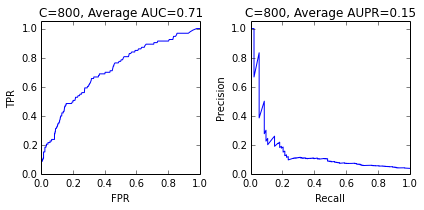

800------------------------------------


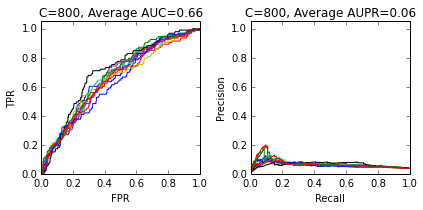

2017-04-20 14:50:47


In [13]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep , indep1 10-fold, 1:1  2017.4.19. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_RF_tn_local_norm_indep.txt", 'w') as fd :
    user_estimator = 800
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    #--------------------------------------------------------------
    fd.write("<1:1 independent>\r\n")
    independent_count = 10
    indep_results = dict()
    indep_draw = list()
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        folds_results2, draw_results2, indep_results2= Random_Forest_independent_graph(x_resampled, y_resampled, indep_x, indep_y, user_estimator)
        indep_results[i] = folds_results2
        indep_draw.append(draw_results2)    
    seperated = seperate_results(indep_results)
    final_result = average_result(seperated)
    draw_plot(indep_draw, final_result, user_estimator)
    write_output(fd, final_result, user_estimator)    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [14]:
def predicted_results(fp_results):
    df_predicted_result = pd.DataFrame({'Drug_id':indep['drug_id'],'Disease_id':indep['disease_id'],
                                    'Predicted_label' : fp_results['Predicted_label'],
                                    'Predicted_proba' : fp_results['predicted_proba'][:,1], 
                                    'y_true':fp_results['y_true']})
    return df_predicted_result

res = predicted_results(fp_results)
res[(res.y_true ==1)&(res.Predicted_label ==1)]

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
349,137760,DB01210,1,0.59375,1
384,140600,DB00193,1,0.79250,1
389,165720,DB00193,1,0.79250,1
411,607850,DB00193,1,0.79250,1
489,140600,DB00784,1,0.85875,1
494,165720,DB00784,1,0.85875,1
516,607850,DB00784,1,0.85875,1
772,165720,DB00461,1,0.90750,1
794,607850,DB00461,1,0.90750,1
914,168600,DB00376,1,0.72375,1


2017-04-20 23:43:25
500------------------------------------


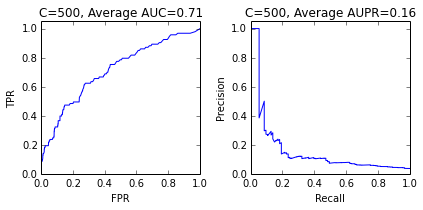

500------------------------------------


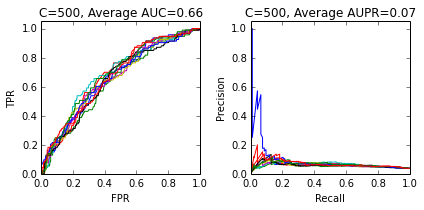

2017-04-20 23:44:12


In [15]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep , indep1 10-fold, 1:1  2017.4.19. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_500_RF_tn_local_norm_indep.txt", 'w') as fd :
    user_estimator = 500
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    #--------------------------------------------------------------
    fd.write("<1:1 independent>\r\n")
    independent_count = 10
    indep_results = dict()
    indep_draw = list()
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        folds_results2, draw_results2, indep_results2= Random_Forest_independent_graph(x_resampled, y_resampled, indep_x, indep_y, user_estimator)
        indep_results[i] = folds_results2
        indep_draw.append(draw_results2)    
    seperated = seperate_results(indep_results)
    final_result = average_result(seperated)
    draw_plot(indep_draw, final_result, user_estimator)
    write_output(fd, final_result, user_estimator)    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-04-21 01:50:00
120------------------------------------


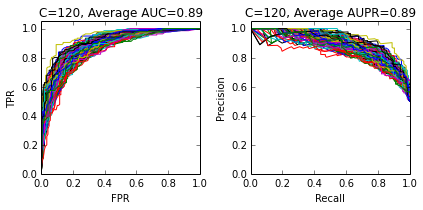

300------------------------------------


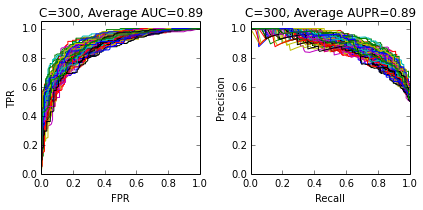

500------------------------------------


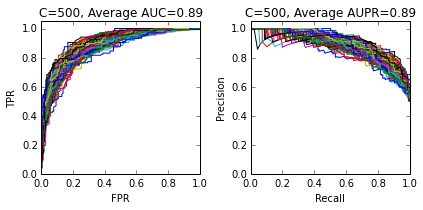

800------------------------------------


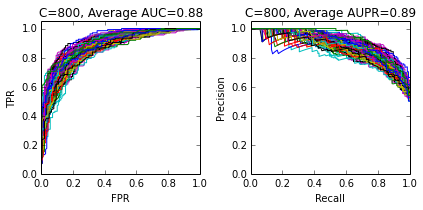

1200------------------------------------


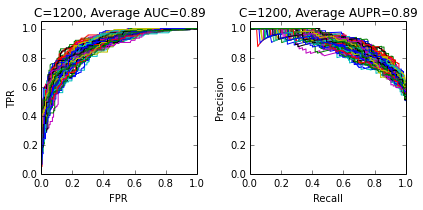

2017-04-21 02:20:30
120------------------------------------


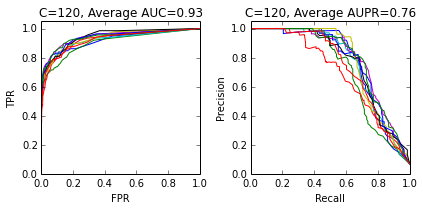

300------------------------------------


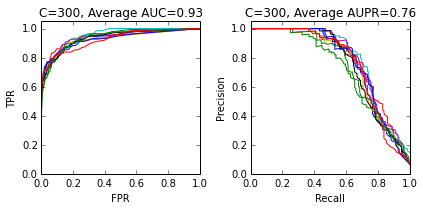

500------------------------------------


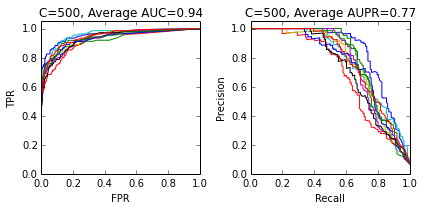

800------------------------------------


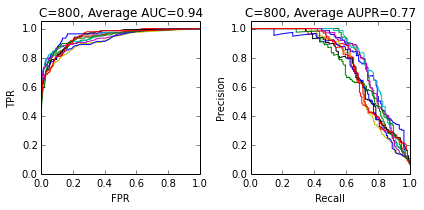

1200------------------------------------


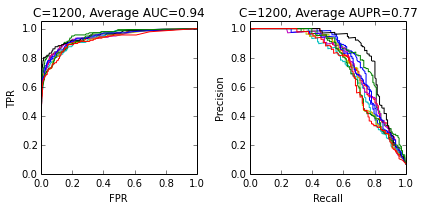

2017-04-21 02:38:30


In [24]:
# RandomForest_K_fold_grpah + 파일 입출력
# PREDICT TN local norm (P:TN = 1: 15), undersampling , 2017.4.20.
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_2_RF_tn_local_norm_1_15_training_10-fold.txt", 'w') as fd :
    fd.write("<10 times independent test : undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 10 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    fd.write("<no independent test -> no undersampling>\r\n")
    param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    draw_total = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    independent_count = 1 # independent test 하고 싶은 횟수, 횟수만큼 랜덤 추출 하여 k-fold cv를 돌린다.
    k = 10 # k-fold cv
    for i in range(independent_count):
        #x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        for user_estimator in [120,300,500,800,1200]:
            folds_results, draw_results = Random_Forest_K_fold_graph(x_whole_data, y_whole_data, k, user_estimator)
            #folds_results, draw_results = Random_Forest_K_fold_graph(x_resampled, y_resampled, k, user_estimator)
            avg_result = average_result(folds_results) # parameter 별로 K-fold한 결과와 average를 구한다.
            param_results[user_estimator].append(avg_result) # parameter 별로 indepedent 결과 저장한다.
            draw_total[user_estimator].append(draw_results)

    final_param_results = {120:[], 300:[], 500:[], 800:[], 1200:[]}
    for user_estimator in [120,300,500,800,1200]: #independent 결과를 parameter별로 평균 낸다.
        indep_results = independent_results(param_results[user_estimator])
        final_param_results[user_estimator] = final_results(indep_results)
        draw_plot(draw_total[user_estimator], final_param_results[user_estimator], user_estimator)
        write_output(fd, final_param_results[user_estimator], user_estimator)
    print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-04-21 10:58:20
500------------------------------------


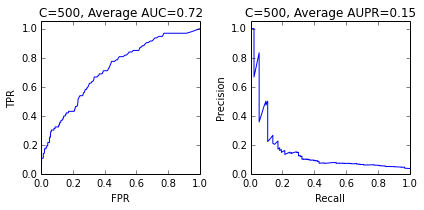

2017-04-21 10:58:29


In [56]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep , indep1 10-fold, 1:1  2017.4.19. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_2_RF_tn_local_norm_1_15_indep.txt", 'w') as fd :
    user_estimator = 500 # 원래는 120으로 해야하는데 밑에 500으로 잘 나온게 있어서 500으로 함
    #근데 왜 aupr이 0.17이 안나오냐 흑흑
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    #--------------------------------------------------------------
    '''fd.write("<1:1 independent>\r\n")
    independent_count = 10
    indep_results = dict()
    indep_draw = list()
    for i in range(independent_count):
        x_resampled, y_resampled = rus.fit_sample(x_whole_data, y_whole_data)
        folds_results2, draw_results2, indep_results2= Random_Forest_independent_graph(x_resampled, y_resampled, indep_x, indep_y, user_estimator)
        indep_results[i] = folds_results2
        indep_draw.append(draw_results2)    
    seperated = seperate_results(indep_results)
    final_result = average_result(seperated)
    draw_plot(indep_draw, final_result, user_estimator)
    write_output(fd, final_result, user_estimator)    '''
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-04-21 11:26:00
1200------------------------------------


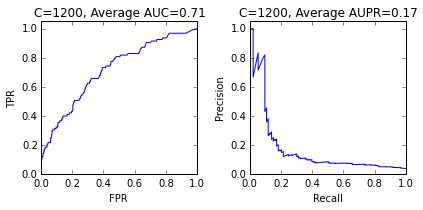

2017-04-21 11:26:20


In [65]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep , indep1 10-fold, 1:1  2017.4.19. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_3_RF_tn_local_norm_1_20_indep.txt", 'w') as fd :
    user_estimator = 1200
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2017-04-21 11:40:38
800------------------------------------


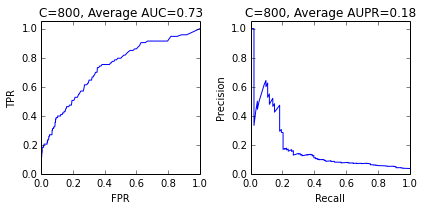

2017-04-21 11:41:02


In [74]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep , indep1 10-fold, 1:1  2017.4.19. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_4_RF_tn_local_norm_1_30_indep.txt", 'w') as fd :
    user_estimator = 800 
    #500
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [95]:
res = predicted_results(fp_results)
print len(res)
print len(res[res.y_true ==1])
print len(res[res.y_true ==1]['Drug_id'].drop_duplicates())
print len(res[res.y_true ==1]['Disease_id'].drop_duplicates())

2539
93
73
35


In [92]:
fn = res[(res.y_true ==1)&(res.Predicted_label ==0)]
print len(fn)
print len(fn.drop_duplicates('Drug_id'))
print len(fn.drop_duplicates('Disease_id'))

76
61
34


In [94]:
tp = res[(res.y_true ==1)&(res.Predicted_label ==1)]
print len(tp)
print len(tp.drop_duplicates('Drug_id'))
print len(tp.drop_duplicates('Disease_id'))

17
12
6


In [97]:
fp = res[(res.y_true ==0)&(res.Predicted_label ==1)]
print len(fp)
print len(fp.drop_duplicates('Drug_id'))
print len(fp.drop_duplicates('Disease_id'))

36
19
10


In [98]:
tn = res[(res.y_true ==0)&(res.Predicted_label ==0)]
print len(tn)
print len(tn.drop_duplicates('Drug_id'))
print len(tn.drop_duplicates('Disease_id'))

2410
73
35


In [129]:
res.head()

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
0,102300,DB01200,0,0.03125,1
1,103780,DB01200,0,0.05375,0
2,104300,DB01200,0,0.02500,0
3,115195,DB01200,0,0.00000,0
4,137580,DB01200,0,0.00500,0


In [133]:
cnt = res[res.y_true == 1 ].groupby('Drug_id').count()[['y_true']]
cnt.head(2)

,y_true
Drug_id,
DB00125,1
DB00136,1


In [134]:
cnt.reset_index(level='Drug_id', inplace=True)

In [135]:
cnt.groupby('y_true').count()

,Drug_id
y_true,
1,59
2,8
3,6


In [142]:
df_sorted = cnt.sort_values('y_true', ascending=False)
query = df_sorted[df_sorted.y_true > 1]
query

,Drug_id,y_true
36,DB00784,3
22,DB00531,3
4,DB00193,3
40,DB00860,3
68,DB01399,3
45,DB00939,3
15,DB00384,2
27,DB00619,2
19,DB00461,2
58,DB01085,2


In [148]:
a = res[res['Drug_id'].isin(query['Drug_id'])]
a[a.y_true ==1].sort_values('Drug_id')

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
384,140600,DB00193,1,0.57000,1
389,165720,DB00193,1,0.57000,1
411,607850,DB00193,1,0.57000,1
1418,602522,DB00384,0,0.02375,1
1413,263800,DB00384,0,0.00000,1
1453,602522,DB00421,0,0.02125,1
1448,263800,DB00421,0,0.00250,1
794,607850,DB00461,1,0.84000,1
772,165720,DB00461,1,0.84000,1
715,256370,DB00531,0,0.13625,1


In [155]:
# disease dependent?
cnt2 = res[res.y_true == 1 ].groupby('Disease_id').count()[['y_true']]
cnt2.head(2)

,y_true
Disease_id,
102300,1
103780,1


In [156]:
cnt2.reset_index(level='Disease_id', inplace=True)

In [157]:
cnt2.groupby('y_true').count()

,Disease_id
y_true,
1,17
2,7
3,3
4,2
5,4
6,1
19,1


In [164]:
df_sorted2 = cnt2.sort_values('y_true', ascending=False)
query2 = df_sorted2[df_sorted2.y_true > 1]
query2

,Disease_id,y_true
31,603165,19
14,168600,6
34,607850,5
33,607501,5
12,165720,5
6,137760,5
7,140600,4
11,152700,4
13,166710,3
28,601626,3


In [187]:
a2 = res[res['Disease_id'].isin(query2['Disease_id'])]
b = a2[a2.y_true ==1].sort_values('Disease_id')
print len(b['Disease_id'].drop_duplicates())
print len((b['Drug_id'].drop_duplicates()))
b.head()

18
61


,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
106,115195,DB00280,0,0.00000,1
141,115195,DB00343,0,0.02250,1
212,137750,DB00819,0,0.10500,1
246,137750,DB01085,0,0.02625,1
315,137760,DB00521,0,0.32250,1


In [183]:
pd.pivot_table(b, index=['Disease_id'], columns=['Predicted_label'], aggfunc='count')

Drug_id      Predicted_proba      y_true     
Predicted_label       0    1               0    1      0    1
Disease_id                                                   
115195              2.0  NaN             2.0  NaN    2.0  NaN
137750              2.0  NaN             2.0  NaN    2.0  NaN
137760              5.0  NaN             5.0  NaN    5.0  NaN
140600              2.0  2.0             2.0  2.0    2.0  2.0
152700              4.0  NaN             4.0  NaN    4.0  NaN
165720              2.0  3.0             2.0  3.0    2.0  3.0
166710              3.0  NaN             3.0  NaN    3.0  NaN
168600              3.0  3.0             3.0  3.0    3.0  3.0
194200              2.0  NaN             2.0  NaN    2.0  NaN
254800              2.0  NaN             2.0  NaN    2.0  NaN
256370              2.0  NaN             2.0  NaN    2.0  NaN
263800              3.0  NaN             3.0  NaN    3.0  NaN
601626              3.0  NaN             3.0  NaN    3.0  NaN
602522              2.0  NaN             2.0  NaN    2.0  NaN
603165             18.0  1.0            18.0  1.0   18.0  1.0
607499              2.0  NaN             2.0  NaN    2.0  NaN
607501              NaN  5.0             NaN  5.0    NaN  5.0
607850              2.0  3.0             2.0  3.0    2.0  3.0

In [195]:
b[(b.Disease_id == 140600) | (b.Disease_id == 603165) | (b.Disease_id == 607850)]

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
454,140600,DB01399,0,0.241250,1
384,140600,DB00193,1,0.570000,1
489,140600,DB00784,1,0.670000,1
419,140600,DB00939,0,0.118750,1
1975,603165,DB01410,0,0.135000,1
2010,603165,DB00253,0,0.132500,1
2045,603165,DB00283,0,0.076250,1
2080,603165,DB00341,0,0.083750,1
2115,603165,DB00748,0,0.078750,1
2150,603165,DB00950,0,0.092500,1


In [197]:
c[(c.Disease_id == 140600) | (c.Disease_id == 603165) | (c.Disease_id == 607850)].sort_values(["Disease_id","Drug_id"])

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
384,140600,DB00193,1,0.57000,1
489,140600,DB00784,1,0.67000,1
419,140600,DB00939,0,0.11875,1
454,140600,DB01399,0,0.24125,1
411,607850,DB00193,1,0.57000,1
794,607850,DB00461,1,0.84000,1
516,607850,DB00784,1,0.67000,1
446,607850,DB00939,0,0.11875,1
481,607850,DB01399,0,0.24125,1


In [188]:
c = b[b['Drug_id'].isin(query['Drug_id'])].sort_values('Drug_id')
c

,Disease_id,Drug_id,Predicted_label,Predicted_proba,y_true
411,607850,DB00193,1,0.57000,1
384,140600,DB00193,1,0.57000,1
389,165720,DB00193,1,0.57000,1
1413,263800,DB00384,0,0.00000,1
1418,602522,DB00384,0,0.02375,1
1448,263800,DB00421,0,0.00250,1
1453,602522,DB00421,0,0.02125,1
794,607850,DB00461,1,0.84000,1
772,165720,DB00461,1,0.84000,1
715,256370,DB00531,0,0.13625,1


In [189]:
pd.pivot_table(c, index=['Disease_id'], columns=['Predicted_label'], aggfunc='count')

Drug_id      Predicted_proba      y_true     
Predicted_label       0    1               0    1      0    1
Disease_id                                                   
137750              2.0  NaN             2.0  NaN    2.0  NaN
137760              2.0  NaN             2.0  NaN    2.0  NaN
140600              2.0  2.0             2.0  2.0    2.0  2.0
152700              2.0  NaN             2.0  NaN    2.0  NaN
165720              2.0  3.0             2.0  3.0    2.0  3.0
168600              1.0  NaN             1.0  NaN    1.0  NaN
256370              2.0  NaN             2.0  NaN    2.0  NaN
263800              2.0  NaN             2.0  NaN    2.0  NaN
601626              1.0  NaN             1.0  NaN    1.0  NaN
602522              2.0  NaN             2.0  NaN    2.0  NaN
607850              2.0  3.0             2.0  3.0    2.0  3.0

In [191]:
pd.pivot_table(c, index=['Drug_id'], columns=['Predicted_label'], aggfunc='count')

Disease_id      Predicted_proba      y_true     
Predicted_label          0    1               0    1      0    1
Drug_id                                                         
DB00193                NaN  3.0             NaN  3.0    NaN  3.0
DB00384                2.0  NaN             2.0  NaN    2.0  NaN
DB00421                2.0  NaN             2.0  NaN    2.0  NaN
DB00461                NaN  2.0             NaN  2.0    NaN  2.0
DB00531                2.0  NaN             2.0  NaN    2.0  NaN
DB00619                1.0  NaN             1.0  NaN    1.0  NaN
DB00784                NaN  3.0             NaN  3.0    NaN  3.0
DB00819                2.0  NaN             2.0  NaN    2.0  NaN
DB00860                2.0  NaN             2.0  NaN    2.0  NaN
DB00939                3.0  NaN             3.0  NaN    3.0  NaN
DB01037                1.0  NaN             1.0  NaN    1.0  NaN
DB01085                2.0  NaN             2.0  NaN    2.0  NaN
DB01399                3.0  NaN             3.0  NaN    3.0  NaN

2017-04-24 15:51:24
800------------------------------------


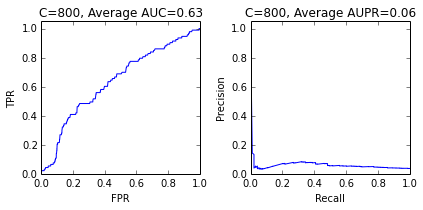

2017-04-24 15:51:29


In [13]:
# Random_Forest_independent_graph + 파일 입출력 + 1:1
# PREDICT TN local norm indep (P:TN = 1:1) , indep1 10-fold, 1:1  2017.4.23. 작성
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
path = '/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/5_final/'
with open(path + "2_2_5_RF_tn_local_norm_1_1_indep.txt", 'w') as fd :
    user_estimator = 800 
    
    fd.write("<independent>\r\n")
    folds_results, draw_results, fp_results = Random_Forest_independent_graph(x_whole_data, y_whole_data, indep_x, indep_y, user_estimator)
    draw_plot([draw_results], folds_results, user_estimator)
    write_output(fd, folds_results, user_estimator)
    
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')